# Orbit Interpolation Analysis


In [64]:
import requests
from datetime import datetime, timedelta
import numpy as np
from skyfield.api import load
from skyfield.sgp4lib import EarthSatellite

ts = load.timescale()

def download_tle(scid):
    url = "https://celestrak.org/NORAD/elements/gp.php?GROUP=active&FORMAT=tle"

    # Send an HTTP GET request to the URL
    response = requests.get(url)

    # Check if the request was successful
    if response.status_code == 200:
        # Split the content of the response into lines
        lines = response.text.splitlines()

        for i in range(0, len(lines)):
            if lines[i].strip() == scid:
                return lines[i + 1], lines[i + 2]
    else:
        print(f"Failed to retrieve content from the URL: {url}")
        return None, None
    
def time_range(start: datetime, end: datetime, step: timedelta):
    """
    Simple function to generate a list of times using start, end and step
    If this exists elsewhere, I'm happy to call it
    """

    t = start
    while t <= end:
        yield ts.utc(t)
        t += step



In [65]:
import ipywidgets as widgets
from datetime import datetime, timedelta, timezone

# Text widget
scif_widget = widgets.Text(
    value='ISS (ZARYA)',
    description='Satellite Name:',
)


# Date picker for today
start_widget = widgets.Text(
    value=str(datetime.now(timezone.utc)),
    description='Start Time'
)

end_widget = widgets.Text(
    value=str(datetime.now(timezone.utc) + timedelta(hours=3)),
    description='End Time'
)

# Numeric text box
sample_sec_widgets = widgets.BoundedIntText(
    value=120,
    min=0,
    max=1000,
    step=1,
    description='Sample(sec):',
)

# Display widgets
display(scif_widget, start_widget, end_widget, sample_sec_widgets)


Text(value='ISS (ZARYA)', description='Satellite Name:')

Text(value='2024-05-01 18:26:51.284809+00:00', description='Start Time')

Text(value='2024-05-01 21:26:51.285404+00:00', description='End Time')

BoundedIntText(value=120, description='Sample(sec):', max=1000)

In [71]:

# download the current TLE and create a satellite
from skyfield.timelib import Time

print(scif_widget.value)
tle1, tle2 = download_tle(scif_widget.value)
satellite = EarthSatellite(tle1, tle2)


# create the sample times 
sample_times = list(time_range(
    datetime.fromisoformat(start_widget.value), 
    datetime.fromisoformat(end_widget.value), 
    timedelta(seconds=sample_sec_widgets.value)))

# create the 1hz times for comparison
times_1sec = list(time_range(
    datetime.fromisoformat(start_widget.value), 
    datetime.fromisoformat(end_widget.value), 
    timedelta(seconds=1)))

sample_timestamps = [t.utc_datetime().timestamp() for t in sample_times]
times_1sec_timestamps = [t.utc_datetime().timestamp() for t in times_1sec]





TypeError: cannot unpack non-iterable NoneType object

In [67]:
def generate_state_vectors(sat: EarthSatellite, times: list[datetime]) -> tuple[np.ndarray, np.ndarray]:
    pos = []
    vel = []

    for t in times:
        sv = sat.at(t)
        pos.append(sv.position.km)
        vel.append(sv.velocity.km_per_s)

    return np.array(pos), np.array(vel)    



pos_samples,vel_samples = generate_state_vectors(satellite, sample_times)
pos_1sec, vel_1sec = generate_state_vectors(satellite, times_1sec)

print(f"Generated Samples with size: {np.shape(pos_samples)}")
print(f"Generated 1 sec Samples with size: {np.shape(pos_1sec)}")

Generated Samples with size: (91, 3)
Generated 1 sec Samples with size: (10801, 3)


Text(0.5, 1.0, 'Satellite Position (ECI) at Sample Points')

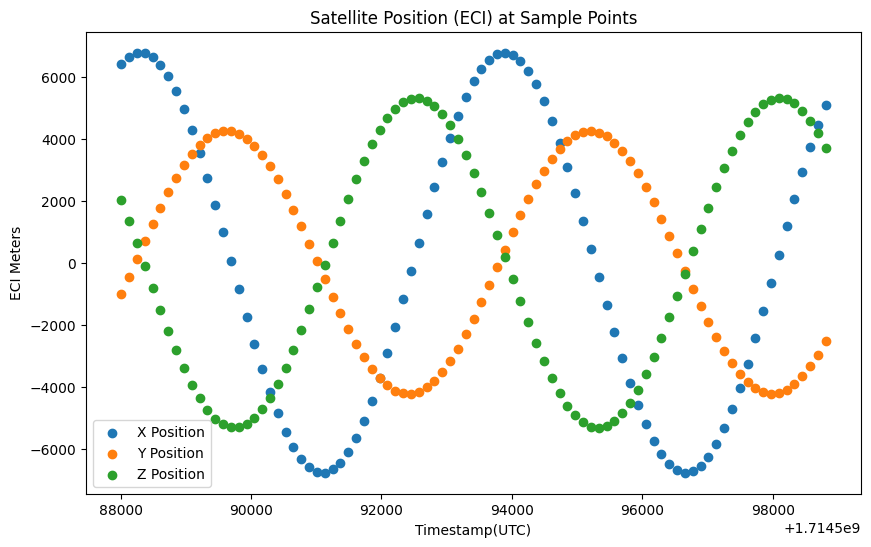

In [68]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Set up the plot
plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size

# Plot each series
plt.scatter(sample_timestamps, pos_samples[:, 0], label=f'X Position')  # Plot each column and label it
plt.scatter(sample_timestamps, pos_samples[:, 1], label=f'Y Position')  # Plot each column and label it
plt.scatter(sample_timestamps, pos_samples[:, 2], label=f'Z Position')  # Plot each column and label it

# Add legend, labels, and title
plt.legend()
plt.xlabel('Timestamp(UTC)')
plt.ylabel('ECI Meters')
plt.title('Satellite Position (ECI) at Sample Points')

Text(0.5, 1.0, 'Satellite Velocity (ECI) at Sample Points')

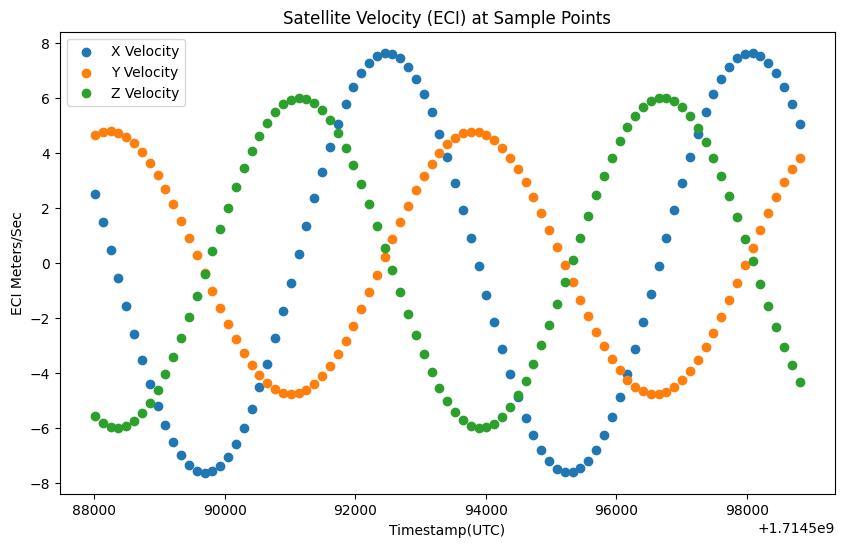

In [69]:
# Set up the plot
plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size

# Plot each series
plt.scatter(sample_timestamps, vel_samples[:, 0], label=f'X Velocity')  # Plot each column and label it
plt.scatter(sample_timestamps, vel_samples[:, 1], label=f'Y Velocity')  # Plot each column and label it
plt.scatter(sample_timestamps, vel_samples[:, 2], label=f'Z Velocity')  # Plot each column and label it

# Add legend, labels, and title
plt.legend()
plt.xlabel('Timestamp(UTC)')
plt.ylabel('ECI Km/Sec')
plt.title('Satellite Velocity (ECI) at Sample Points')

In [70]:
from numpy import absolute
from scipy.interpolate import CubicSpline, CubicHermiteSpline, PchipInterpolator, Akima1DInterpolator

def compute_min_max_delta(interpolator, x_timestamps, y_actuals):
    """
    Computes the minimum and maximum delta between actual values and interpolated values.
    
    Args:
    interpolator (scipy.interpolate): The interpolator object (e.g., CubicSpline, CubicHermiteSpline).
    x_timestamps (array-like): The timestamps at which to evaluate the interpolator.
    y_actuals (array-like): The actual position or velocity values at x_timestamps.
    
    Returns:
    tuple: A tuple containing the minimum and maximum deltas for each dimension.
    """
    # Evaluate the interpolator at the given timestamps
    interpolated_values = interpolator(x_timestamps)
    
    # Compute the delta between actual values and interpolated values
    delta = np.abs(y_actuals - interpolated_values)
    
    # Calculate the minimum and maximum delta
    max_delta = np.max(delta, axis=0)

    # Calculate the angular differences
    norms_actual = np.linalg.norm(y_actuals, axis=1)
    norms_interpolated = np.linalg.norm(interpolated_values, axis=1)
    dot_products = np.einsum('ij,ij->i', y_actuals, interpolated_values)
    cos_theta = dot_products / (norms_actual * norms_interpolated)
    
    # Numerical issues might make cos_theta slightly > 1 or < -1, correct those
    cos_theta = np.clip(cos_theta, -1, 1)
    
    # Compute angular differences in radians
    angular_differences = np.arccos(cos_theta)

    absolute_differences = np.abs(norms_actual - norms_interpolated)
    
    # Get the maximum angular difference
    max_angular_difference = np.degrees(np.max(angular_differences))
    max_absolute_difference = np.max(absolute_differences)


    print(f"max delta (m) by components: {max_delta * 1000}")
    print(f"max absolute delta (m): {max_absolute_difference * 1000}")
    print(f"max angular difference (deg): {max_angular_difference}")
    print()
    

cubic_pos_interp = CubicSpline(sample_timestamps, pos_samples, extrapolate=False)
hermite_pos_interp = CubicHermiteSpline(sample_timestamps, pos_samples, vel_samples, extrapolate=False)

print("Cubic (Pos)")
compute_min_max_delta(cubic_pos_interp, times_1sec_timestamps, pos_1sec)
print("CubicHermite (Pos)")
compute_min_max_delta(hermite_pos_interp, times_1sec_timestamps, pos_1sec)

cubic_vel_interp = CubicSpline(sample_timestamps, vel_samples, extrapolate=False)
pchip_vel_interp = PchipInterpolator(sample_timestamps, vel_samples, extrapolate=False)
akima_vel_interp = Akima1DInterpolator(sample_timestamps, vel_samples)

print("Cubic (Vel)")
compute_min_max_delta(cubic_vel_interp, times_1sec_timestamps, vel_1sec)
print("PCHIP (Vel)")
compute_min_max_delta(pchip_vel_interp, times_1sec_timestamps, vel_1sec)
print("Akima (Vel)")
compute_min_max_delta(akima_vel_interp, times_1sec_timestamps, vel_1sec)


Cubic (Pos)
max delta (m) by components: [63.82567841 28.48957088 40.26407117]
max absolute delta (m): 64.8938902604641
max angular difference (deg): 5.512628076817721e-05

CubicHermite (Pos)
max delta (m) by components: [5.98166897 3.67568753 4.59874004]
max absolute delta (m): 6.009979922055209
max angular difference (deg): 1.7075472925031877e-06

Cubic (Vel)
max delta (m) by components: [0.05630852 0.04639379 0.05711456]
max absolute delta (m): 0.07461822275445229
max angular difference (deg): 6.169659253665933e-05

PCHIP (Vel)
max delta (m) by components: [17.15507301 10.27043908 13.60746348]
max absolute delta (m): 17.118737698495146
max angular difference (deg): 0.08693901660166732

Akima (Vel)
max delta (m) by components: [1.20680293 0.74508064 0.94989538]
max absolute delta (m): 0.14797511204278635
max angular difference (deg): 0.009069556681093247

